In [1]:
!pip install causalnex
!pip install tigramite

In [3]:
import os

import numpy as np

os.chdir("/project/lcd_v2")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
from tqdm.notebook import tqdm
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

from causalnex.structure.dynotears import from_pandas_dynamic
sys.path.append('/project/lcd_v2/run')
from external.Neural_GC.models import cmlp as _cmlp
from external.SRU_for_GCI.utils.utilFuncs import loadTrainingData, loadTrueNetwork
from external.Neural_GC.main import compute_lam_by_sweeping, compute_lam_multi_process, compute_lam_by_sweeping_v2

from tigramite.independence_tests.parcorr import ParCorr
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI

In [4]:
def normalize(X):
    # centering
    return X - X.mean()

def parse_examples(data_paths):
    Xtrain = loadTrainingData(data_paths[0], 'cpu').T
    Xtrain = normalize(Xtrain)
    l, n = Xtrain.shape
    Gref = loadTrueNetwork(data_paths[1], n).T  # entry (i,j) is the causal link i -> j

    # Load data
    # Use the full length of the time series
    examples = []
    duration = 21

    # parse it into 46 snippets of sequences (the length of each one is 21 )
    for start in range(0, l, duration):
        examples.append(
            {
                "seqs": np.array(Xtrain[start:start + duration, :]),
                "label": Gref,
            }
        )
    print("data shape: ", Xtrain.shape, "graph shape: ", Gref.shape)
    # examples.append(
    #     {
    #         "seqs": np.array(Xtrain),
    #         "label": Gref,
    #     }
    # )
    return examples

def eval_by_neural_granger_causality(examples, method="cmlp"):
    assert method in ["cmlp", "clstm", "sru", "esru_2LF", "esru_1LF"], f"method {method} not supported"
    method = f"compute_lam_{method}"

    ts = [examples[i]["seqs"] for i in range(len(examples))]
    Gref = [examples[i]["label"] for i in range(len(examples))]

    grefs, gests = compute_lam_multi_process(ts, Gref, method, "dream3")

    res = []
    for i in range(len(grefs)):
        res.append(
            {
                "pred": gests[i],
                "label": grefs[i],
            }
        )
    return res


def eval_by_pcmciplus(examples, max_lag=3):
    res = []
    for example in tqdm(examples, desc="PCMCI+"):
        X = example["seqs"]
        T, N = X.shape
        var_names = [f'X_{j}' for j in range(N)]
        df = pp.DataFrame(X, var_names=var_names)
        pcmci = PCMCI(dataframe=df,
                      cond_ind_test=ParCorr(significance='analytic'),
                      verbosity=1)
        results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag)
        # Initialize the summary graph as an N x N matrix with zeros
        summary_graph = np.zeros((N, N), dtype=int)
        # Iterate through the matrix G and fill in the summary graph
        for i in range(N):
            for j in range(N):
                for tau in range(max_lag + 1):
                    if results['graph'][i, j, tau] == '-->':
                        summary_graph[i, j] = 1
                        break

        # ignore the diag predictions
        for i in range(N):
            summary_graph[i, i] = 0
        res.append(
            {
                "pred": summary_graph,
                "label": example["label"],
            }
        )

    return res


def eval_by_dynotears(examples, max_lag=2):
    """
    modified from https://github.com/ckassaad/causal_discovery_for_time_series/blob/master/baselines/scripts_python/dynotears.py
    """
    res = []
    for example in tqdm(examples, desc="Dynotears"):
        X = example["seqs"]
        T, N = X.shape
        var_names = [f'X_{j}' for j in range(N)]

        df = pd.DataFrame(X, columns=var_names)
        sm = from_pandas_dynamic(df, lambda_w=0.1, lambda_a=0.01, max_iter=2000, p=max_lag)

        tname_to_name_dict = dict()
        count_lag = 0
        idx_name = 0
        for tname in sm.nodes:
            tname_to_name_dict[tname] = int(df.columns[idx_name].split('_')[-1])
            if count_lag == max_lag:
                idx_name = idx_name + 1
                count_lag = -1
            count_lag = count_lag + 1

        # Initialize the summary graph as an N x N matrix with zeros
        summary_graph = np.zeros((N, N), dtype=int)
        for ce in sm.edges:
            c = ce[0]
            c = tname_to_name_dict[c]
            e = ce[1]
            e = tname_to_name_dict[e]
            summary_graph[c, e] = 1

        # ignore the diag predictions
        for i in range(N):
            summary_graph[i, i] = 0
        res.append(
            {
                "pred": summary_graph,
                "label": example["label"],
            }
        )

    return res



In [5]:
examples = parse_examples(('/project/SRU_for_GCI/data/dream3/Dream3TensorData/Size100Ecoli1.pt',
                   '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Ecoli1.tsv'))

data shape:  torch.Size([966, 100]) graph shape:  (100, 100)


In [8]:
count = 0
files = ['/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Yeast3.tsv',
         '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Yeast2.tsv',
         '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Yeast1.tsv',
         '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Ecoli1.tsv',
         '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-Ecoli2.tsv',]
for file in files:
    count += loadTrueNetwork(file, 100).sum()
count/5

270.0

In [9]:
res = eval_by_dynotears(examples)

Dynotears:   0%|          | 0/46 [00:00<?, ?it/s]

NameError: name 'pd' is not defined

In [14]:
# merge the examples to one input
ts = [np.stack([examples[i]["seqs"] for i in range(len(examples))], axis=0)]
print(ts[0].shape)
Gref = [examples[0]["label"]]

# mp.set_start_method('spawn', force=True)
grefs, gests, stat_dict = compute_lam_by_sweeping_v2(ts, Gref, "compute_lam_clstm", dataset="dream3")

(46, 21, 100)


  0%|                                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

torch.Size([46, 21, 100])
torch.Size([46, 20, 100]) torch.Size([46, 20, 100])
----------Iter = 100----------
Loss = 621.269592
Variable usage = 100.00%
----------Iter = 200----------
Loss = 297.935028
Variable usage = 99.99%
----------Iter = 300----------
Loss = 20.751709
Variable usage = 39.04%
----------Iter = 400----------
Loss = 1.292786
Variable usage = 0.00%
----------Iter = 500----------
Loss = 0.502480
Variable usage = 0.00%
----------Iter = 600----------
Loss = 0.208512
Variable usage = 0.00%
----------Iter = 700----------
Loss = 0.097363
Variable usage = 0.00%
----------Iter = 800----------
Loss = 0.053875
Variable usage = 0.00%
----------Iter = 900----------
Loss = 0.035691
Variable usage = 0.00%
----------Iter = 1000----------
Loss = 0.027184
Variable usage = 0.00%
----------Iter = 1100----------
Loss = 0.022552
Variable usage = 0.00%
----------Iter = 1200----------
Loss = 0.019609
Variable usage = 0.00%
----------Iter = 1300----------
Loss = 0.017504
Variable usage = 0.00%

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:47<00:00, 527.91s/it]


In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score
for i in range(grefs[0].shape[0]):
    grefs[0][i, i] = 0
    gests[0][i, i] = 0

roc_auc_score(grefs[0].flatten(), gests[0].flatten()), average_precision_score(grefs[0].flatten(), gests[0].flatten())

IndexError: invalid index to scalar variable.

In [10]:
grefs, gests

(0.5260253164556963, 0.268)

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score

# convert all graphs into a summary graph
# if there is a edge at any time step, then we consider it as a edge

def convert_to_summary_graph(res):
    N = res[0]["pred"].shape[0]
    if len(res) > 1:
        summary_graph = np.zeros((N, N))

        for i in range(N):
            for j in range(N):
                for example in res:
                    if example["pred"][i, j] >  summary_graph[i, j]:
                        summary_graph[i, j] = example["pred"][i, j]
                        # break
        label_graph = np.where(examples[0]["label"]!=0, 1, 0)
    else:
        summary_graph = res[0]["pred"]
        label_graph = np.where(res[0]["label"]!=0, 1, 0)

    print(summary_graph)

    # for i in range(N):
    #     summary_graph[i, i] = 0
    #     label_graph[i, i] = 0
    mask = np.eye(label_graph.shape[0], dtype=bool)
    summary_graph = summary_graph[~mask]
    label_graph = label_graph[~mask]

    return summary_graph.flatten(), label_graph.flatten()

### Visualization

In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
import torch


os.chdir("/project/lcd_v2")
from run.tools.cli.infer import prepare_inference



dataset_id = ['Ecoli2', 'Yeast2', 'Yeast3']
methods = ['correlation', 'granger_causality', 'mutual_info', 'cmlp', 'clstm', 'pcmciplus', 'esru', 'sru']
    # ['dynotears', 'pcmciplus', 'esru', 'sru']

In [22]:
# helper function
def float2binary(l):
    l = np.where(l!=0, 1, 0)
    return l

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [23]:
res = {i: {method: pickle.load(open(f"/project/lcd_v2/.cache/sim_data/normalized/dream3_auc_result/dataset=dream3_{i}-method={method}.pkl", "rb")) for method in methods} for i in dataset_id}

In [24]:
# load other baselines result
score = {}

for idx in dataset_id:
    score[idx] = {}
    score_auroc, score_auprc = [], []
    for method in methods:
        score[idx][method] = {}
        pred, label = convert_to_summary_graph(res[idx][method])
        pred = np.abs(np.where(pred==np.inf, 200, pred))
        score[idx][method] = {'auroc': roc_auc_score(label, pred),
                              'auprc': average_precision_score(label, pred)}
       # print mean and std of each method
        print(f"dataset {idx}, method {method}, auroc: {score[idx][method]['auroc']}, auprc: {score[idx][method]['auprc']}")
        print("--------------------------")


[[0.         0.94435339 0.93023985 ... 0.87224263 0.94229193 0.86152731]
 [0.94435339 0.         0.83412684 ... 0.89266573 0.57676249 0.48340265]
 [0.93023985 0.83412684 0.         ... 0.90341693 0.93542362 0.90014633]
 ...
 [0.87224263 0.89266573 0.90341693 ... 0.         0.90955204 0.89405044]
 [0.94229193 0.57676249 0.93542362 ... 0.90955204 0.         0.97552949]
 [0.86152731 0.48340265 0.90014633 ... 0.89405044 0.97552949 0.        ]]
dataset Ecoli2, method correlation, auroc: 0.5086891048593349, auprc: 0.012931753105606552
--------------------------
[[0.         0.54124749 0.02594589 ... 0.19147766 0.         0.20246832]
 [0.05251446 0.         0.12374135 ... 0.15799947 0.12369464 0.08610481]
 [0.00912013 0.45549136 0.         ... 0.27060935 0.10221045 0.16555947]
 ...
 [0.14851521 0.35553816 0.20049883 ... 0.         0.20301002 0.07448845]
 [0.1972117  0.14928098 0.29861802 ... 0.10661177 0.         0.21245457]
 [0.         0.11408847 0.03867196 ... 0.0375475  0.00227973 0.     

In [29]:
import scipy.io as sio
import torch
from pytorch_lightning import Trainer


# load proposed method result
ckpt_path = '/project/lcd_v2/work_dir/dream3_ecoli_transformer_128/ckpts/exp_name=dream3_ecoli_transformer_128-cfg=dream3_ecoli_transformer_64-bs=128-seed=42-val_average_precision=0.5174.ckpt'
cfg_path = 'work_dir/dream3_ecoli_transformer_128/dream3_ecoli_transformer_64.py'

di, mi = prepare_inference(cfg_path, ckpt_path)

mi = mi.cuda()

dataset_id = ["Ecoli2", "Yeast2", "Yeast3"]
base_dataset = ('/project/SRU_for_GCI/data/dream3/Dream3TensorData/Size100[DATA].pt',
             '/project/SRU_for_GCI/data/dream3/TrueGeneNetworks/InSilicoSize100-[DATA].tsv')

for dataset in tqdm(dataset_id):
    data_root = [base_dataset[i].replace("[DATA]", dataset) for i in range(len(base_dataset))]
    di.data_cfg.test.data_root = data_root
    di.setup('test')

    trainer = Trainer(gpus=1)
    res = trainer.test(mi, dataloaders=di.test_dataloader())[0]
    if 'transformer' not in score[dataset]:
        score[dataset]['transformer'] = {}
    score[dataset]['transformer']['auroc'] = res['test_auroc']
    score[dataset]['transformer']['auprc'] = res['test_average_precision']

    # print mean and std of each dataset
    print("--------------------------")
    print(f"dataset {idx}, method transformer, auroc: {score[dataset]['transformer']['auroc']}, auprc: {score[dataset]['transformer']['auprc']}")



/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_FocalLoss_epoch    │   0.004086477681994438    │
│        test_auroc         │    0.7304434180259705     │
│  test_average_precision   │   0.039744384586811066    │
│      test_loss_epoch      │   0.004086477681994438    │
└───────────────────────────┴───────────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------
dataset Yeast3, method transformer, auroc: 0.7304434180259705, auprc: 0.039744384586811066


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_FocalLoss_epoch    │   0.010385947301983833    │
│        test_auroc         │    0.5839539766311646     │
│  test_average_precision   │    0.05750926956534386    │
│      test_loss_epoch      │   0.010385947301983833    │
└───────────────────────────┴───────────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------
dataset Yeast3, method transformer, auroc: 0.5839539766311646, auprc: 0.05750926956534386


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_FocalLoss_epoch    │    0.01433614268898964    │
│        test_auroc         │    0.5298043489456177     │
│  test_average_precision   │   0.062009770423173904    │
│      test_loss_epoch      │    0.01433614268898964    │
└───────────────────────────┴───────────────────────────┘

--------------------------
dataset Yeast3, method transformer, auroc: 0.5298043489456177, auprc: 0.062009770423173904


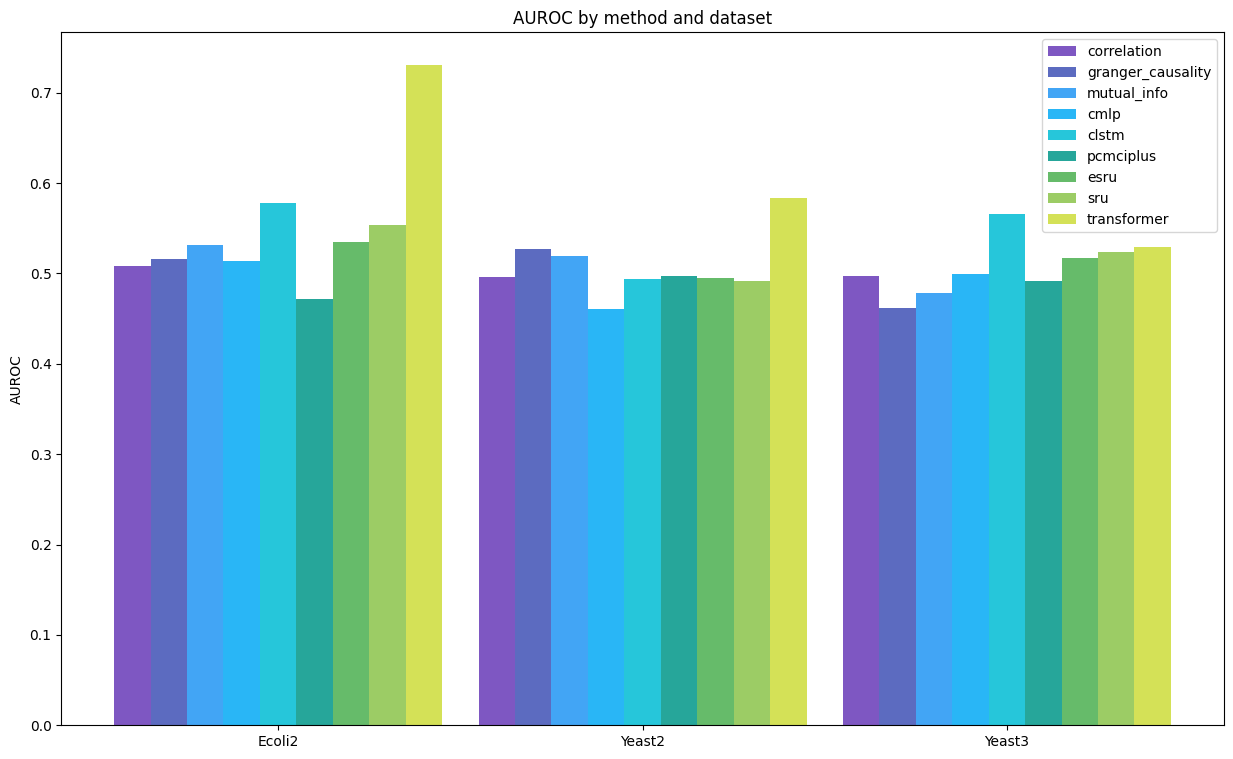

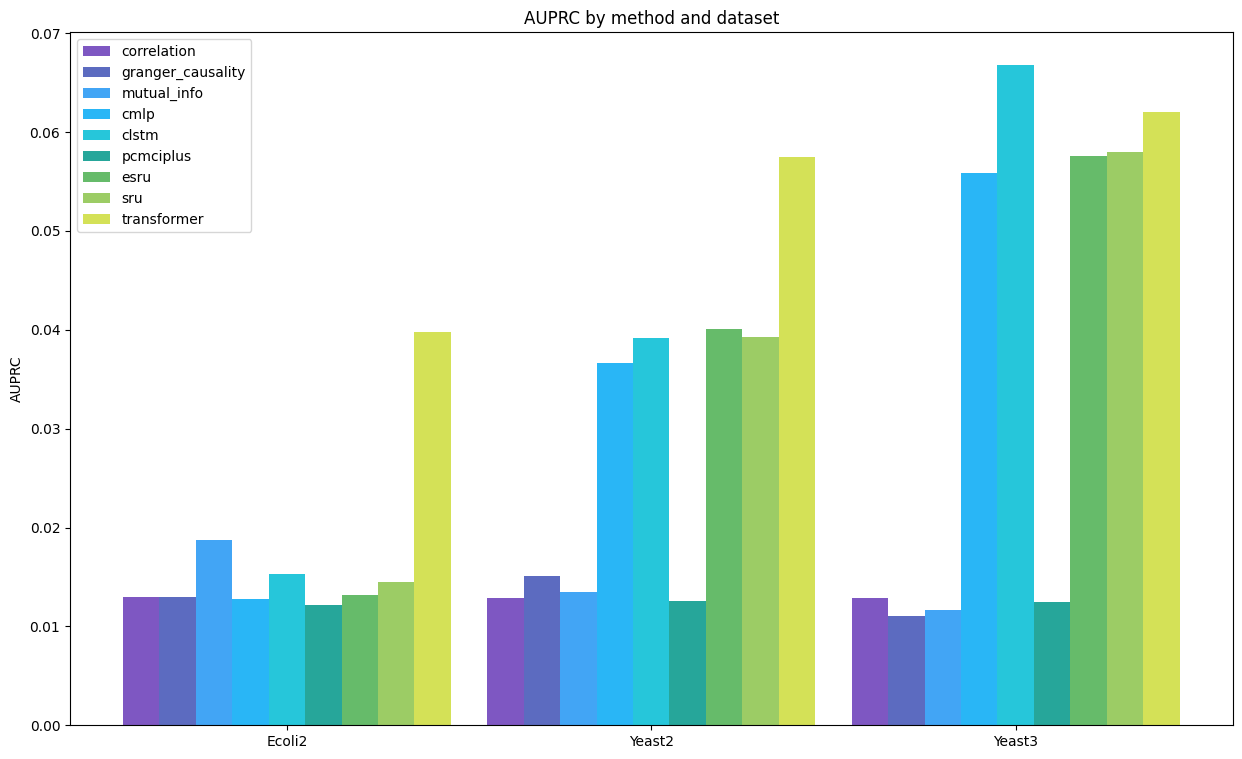

In [30]:
def plot_performance(score, metric="auroc"):
    dataset_names = list(score.keys())
    n_datasets = len(dataset_names)

    # Prepare data for plotting
    method_names = list(next(iter(score.values())).keys())
    n_methods = len(method_names)
    data = {method: [] for method in method_names}
    mean_std_data = {method: {"mean": [], "std": []} for method in method_names}

    for dataset, methods in score.items():
        for method, performance in methods.items():
            data[method].append(performance[metric])
            mean_std_data[method]["mean"].append(np.mean(performance[metric]))
            mean_std_data[method]["std"].append(np.std(performance[metric]))

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(15, 9))
    width = 1 / (n_methods + 1)
    x = np.arange(n_datasets)

    # Use "tab10" colormap for visually pleasing colors
    # colors = plt.cm.tab10(np.linspace(0, 1, n_methods))
    colors =  [
        "#7E57C2", # Purple
        "#5C6BC0", # Indigo
        "#42A5F5", # Blue
        "#29B6F6", # Light Blue
        "#26C6DA", # Cyan
        "#26A69A", # Teal
        "#66BB6A", # Green
        "#9CCC65", # Light Green
        "#D4E157", # Lime
        "#FFEE58", # Yellow
        "#FFCA28", # Amber
    ]

    for idx, (method, performance) in enumerate(data.items()):
        color = colors[idx % len(colors)]
        bar = ax.bar(x + width * idx, mean_std_data[method]["mean"], width, label=method, capsize=4, color=color)
        # bar = ax.bar(x + width * idx, mean_std_data[method]["mean"], width, yerr=mean_std_data[method]["std"], label=method, capsize=4)
        # for i, v in enumerate(mean_std_data[method]["mean"]):
        #     ax.text(
        #         x[i] + width * idx - 0.1,
        #         v + 0.01,
        #         f"{v:.2f}±{mean_std_data[method]['std'][i]:.2f}",
        #         fontsize=8,
        #     )

    # Customize the plot
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} by method and dataset")
    ax.set_xticks(x + width * (n_methods - 1) / 2)
    ax.set_xticklabels(dataset_names)
    ax.legend()

    # Show the plot
    plt.show()

# Call the function with your score dictionary
plot_performance(score, metric="auroc")
plot_performance(score, metric="auprc")

In [32]:
txt = []

metric = 'auroc'
methods_name = ['correlation', 'granger_causality', 'mutual_info', 'pcmciplus','cmlp', 'clstm', 'esru', 'sru', 'transformer']
for id in dataset_id:
    methods = [f"${score[id][method][f'{metric}']:.2f}$" for method in methods_name]
    best_method = np.argmax([score[id][method][f'{metric}'] for method in methods_name])
    methods[best_method] = f"\\textbf{{{score[id][methods_name[best_method]][f'{metric}']:.2f}}}"
    txt.append(f"{id}  & {methods[0]} & {methods[1]} & {methods[2]} & {methods[3]} & {methods[4]} & {methods[5]} & {methods[6]} & {methods[7]} & {methods[8]} \\\\")
open("score_transformer.txt", "w").write("\n".join(txt))

296